In [1]:
### COMPLETE DIAGNOSTIC AND FIX SCRIPT ###

import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import yaml
import torch
import locale
import cv2
import numpy as np
from PIL import Image

# Fix encoding issue
def getpreferredencoding(do_setlocale=True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
### 1. Setup directories and paths ###
INPUT_DIR = '/kaggle/input'
WORKING_DIR = '/kaggle/working'
TEMP_DIR = '/kaggle/temp'

# Dataset paths
DATASET_NAME = "yolo-nerves"
DATASET_PATH = f"{INPUT_DIR}/{DATASET_NAME}"
CONFIG_YAML_PATH = f"{INPUT_DIR}/{DATASET_NAME}/data/config.yaml"

# RGB dataset path (from previous conversion)
rgb_dataset_path = os.path.join(WORKING_DIR, "rgb_dataset")

print(f"Working Directory: {WORKING_DIR}")
print(f"Dataset Path: {DATASET_PATH}")
print(f"RGB Dataset Path: {rgb_dataset_path}")

Working Directory: /kaggle/working
Dataset Path: /kaggle/input/yolo-nerves
RGB Dataset Path: /kaggle/working/rgb_dataset


In [3]:
### 2. Install and import required packages ###
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_package("ultralytics>=8.0.0")

from ultralytics import YOLO

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
### 3. COMPREHENSIVE DATASET ANALYSIS ###
def analyze_dataset_issues():
    """Comprehensive dataset analysis to identify problems"""
    
    print("="*60)
    print(" DATASET DIAGNOSTIC ANALYSIS")
    print("="*60)
    
    # Check if RGB dataset exists, if not, create it first
    if not os.path.exists(rgb_dataset_path):
        print("RGB dataset not found. Creating it first...")
        create_rgb_dataset()
    
    train_images_path = os.path.join(rgb_dataset_path, 'images', 'train')
    train_labels_path = os.path.join(rgb_dataset_path, 'labels', 'train')
    val_images_path = os.path.join(rgb_dataset_path, 'images', 'val')
    val_labels_path = os.path.join(rgb_dataset_path, 'labels', 'val')
    
    print(f"\nChecking paths:")
    print(f"  Train images: {os.path.exists(train_images_path)} - {train_images_path}")
    print(f"  Train labels: {os.path.exists(train_labels_path)} - {train_labels_path}")
    print(f"  Val images: {os.path.exists(val_images_path)} - {val_images_path}")
    print(f"  Val labels: {os.path.exists(val_labels_path)} - {val_labels_path}")
    
    if not all(os.path.exists(p) for p in [train_images_path, train_labels_path, val_images_path, val_labels_path]):
        print(" Some paths are missing!")
        return None
    
    # 1. Check file counts
    train_img_files = [f for f in os.listdir(train_images_path) if f.lower().endswith(('.jpg', '.png', '.jpeg','.tif'))]
    train_label_files = [f for f in os.listdir(train_labels_path) if f.endswith('.txt')]
    val_img_files = [f for f in os.listdir(val_images_path) if f.lower().endswith(('.jpg', '.png', '.jpeg','.tif'))]
    val_label_files = [f for f in os.listdir(val_labels_path) if f.endswith('.txt')]
    
    train_img_count = len(train_img_files)
    train_label_count = len(train_label_files)
    val_img_count = len(val_img_files)
    val_label_count = len(val_label_files)
    
    print(f"\n DATASET STATISTICS:")
    print(f"  Train Images: {train_img_count}")
    print(f"  Train Labels: {train_label_count}")
    print(f"  Val Images: {val_img_count}")
    print(f"  Val Labels: {val_label_count}")
    
    # Check for mismatched counts
    if train_img_count != train_label_count:
        print(f"  WARNING: Train images/labels mismatch!")
    if val_img_count != val_label_count:
        print(f"  WARNING: Val images/labels mismatch!")
    
    # 2. Analyze label files in detail
    print(f"\n  DETAILED LABEL ANALYSIS:")
    
    def analyze_labels_detailed(labels_path, image_files, split_name):
        label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
        
        empty_labels = 0
        class_counts = {0: 0, 1: 0}  # Brachial plexus nerve, Vagus nerve
        bbox_issues = []
        valid_annotations = 0
        
        print(f"\n  {split_name.upper()} SPLIT ANALYSIS:")
        print(f"    Checking {len(label_files)} label files...")
        
        for label_file in label_files:
            label_path = os.path.join(labels_path, label_file)
            
            # Check if corresponding image exists
            img_name_base = os.path.splitext(label_file)[0]
            corresponding_img = None
            for img_file in image_files:
                if os.path.splitext(img_file)[0] == img_name_base:
                    corresponding_img = img_file
                    break
            
            if not corresponding_img:
                bbox_issues.append(f"{label_file} - No corresponding image found")
                continue
            
            try:
                with open(label_path, 'r') as f:
                    content = f.read().strip()
                
                if not content:
                    empty_labels += 1
                    print(f"    Empty label: {label_file}")
                    continue
                
                lines = content.split('\n')
                file_annotations = 0
                
                for line_idx, line in enumerate(lines):
                    line = line.strip()
                    if not line:
                        continue
                    
                    parts = line.split()
                    if len(parts) != 5:
                        bbox_issues.append(f"{label_file}:{line_idx+1} - Wrong format (expected 5 values): {line}")
                        continue
                    
                    try:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:])
                        
                        # Validate class ID
                        if class_id not in [0, 1]:
                            bbox_issues.append(f"{label_file}:{line_idx+1} - Invalid class ID: {class_id}")
                            continue
                        
                        # Check if coordinates are normalized (0-1)
                        if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 
                               0 < width <= 1 and 0 < height <= 1):
                            bbox_issues.append(f"{label_file}:{line_idx+1} - Coords not normalized: {line}")
                            print(f"      Invalid coords in {label_file}: {line}")
                            continue
                        
                        # Check for reasonable bbox sizes (not too small)
                        if width < 0.01 or height < 0.01:
                            bbox_issues.append(f"{label_file}:{line_idx+1} - Bbox too small: {line}")
                            continue
                        
                        class_counts[class_id] += 1
                        valid_annotations += 1
                        file_annotations += 1
                        
                    except ValueError as e:
                        bbox_issues.append(f"{label_file}:{line_idx+1} - Parse error: {line}")
                        continue
                
                if file_annotations == 0:
                    print(f"    No valid annotations in: {label_file}")
                        
            except Exception as e:
                bbox_issues.append(f"{label_file} - Read error: {str(e)}")
        
        print(f"    Results:")
        print(f"      Total label files: {len(label_files)}")
        print(f"      Empty label files: {empty_labels}")
        print(f"      Valid annotations: {valid_annotations}")
        print(f"      Brachial plexus nerve: {class_counts[0]}")
        print(f"      Vagus nerve: {class_counts[1]}")
        print(f"      Issues found: {len(bbox_issues)}")
        
        if bbox_issues:
            print(f"    First 5 issues:")
            for issue in bbox_issues[:5]:
                print(f"       {issue}")
        
        return empty_labels, class_counts, bbox_issues, valid_annotations
    
    # Analyze both splits
    train_empty, train_classes, train_issues, train_valid = analyze_labels_detailed(
        train_labels_path, train_img_files, "train")
    val_empty, val_classes, val_issues, val_valid = analyze_labels_detailed(
        val_labels_path, val_img_files, "val")
    
    # 3. Sample a few images and their annotations
    print(f"\n  SAMPLE IMAGE & ANNOTATION CHECK:")
    
    def check_sample_annotations(images_path, labels_path, image_files, split_name, num_samples=3):
        print(f"\n  {split_name.upper()} SAMPLES:")
        
        sample_files = image_files[:num_samples] if len(image_files) >= num_samples else image_files
        
        for img_file in sample_files:
            img_path = os.path.join(images_path, img_file)
            label_file = os.path.splitext(img_file)[0] + '.txt'
            label_path = os.path.join(labels_path, label_file)
            
            # Load and check image
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"     {img_file}: Cannot load image")
                    continue
                    
                h, w, c = img.shape
                print(f"     {img_file}: {w}x{h}x{c}, type: {img.dtype}")
                
                # Check label
                if os.path.exists(label_path):
                    with open(label_path, 'r') as f:
                        label_content = f.read().strip()
                    
                    if label_content:
                        lines = label_content.split('\n')
                        print(f"         Labels: {len([l for l in lines if l.strip()])} annotations")
                        
                        # Show first annotation
                        for line in lines:
                            line = line.strip()
                            if line:
                                parts = line.split()
                                if len(parts) == 5:
                                    class_id, x, y, w_norm, h_norm = parts
                                    class_name = "Brachial plexus" if class_id == "0" else "Vagus nerve"
                                    print(f"         - {class_name}: center=({x},{y}), size=({w_norm},{h_norm})")
                                break
                    else:
                        print(f"         Labels: EMPTY FILE")
                else:
                    print(f"         Labels: MISSING")
                    
            except Exception as e:
                print(f"     {img_file}: Error - {str(e)}")
    
    check_sample_annotations(train_images_path, train_labels_path, train_img_files, "train")
    check_sample_annotations(val_images_path, val_labels_path, val_img_files, "val")
    
    # Summary
    total_train_valid = train_valid
    total_val_valid = val_valid
    
    print(f"\n ANALYSIS SUMMARY:")
    print(f"  Total valid training annotations: {total_train_valid}")
    print(f"  Total valid validation annotations: {total_val_valid}")
    print(f"  Training issues: {len(train_issues)}")
    print(f"  Validation issues: {len(val_issues)}")
    
    return {
        'train_valid': total_train_valid,
        'val_valid': total_val_valid,
        'train_empty': train_empty,
        'val_empty': val_empty,
        'train_classes': train_classes,
        'val_classes': val_classes,
        'train_issues': len(train_issues),
        'val_issues': len(val_issues)
    }

In [5]:
### 4. Create RGB dataset function ###
def create_rgb_dataset():
    """Convert original dataset to RGB format"""
    print("Creating RGB dataset...")
    
    original_train_images = "/kaggle/input/yolo-nerves/data/images/train"
    original_val_images = "/kaggle/input/yolo-nerves/data/images/val"
    original_train_labels = "/kaggle/input/yolo-nerves/data/labels/train"
    original_val_labels = "/kaggle/input/yolo-nerves/data/labels/val"
    
    # Create RGB dataset directories
    os.makedirs(rgb_dataset_path, exist_ok=True)
    
    for split, (img_src, lbl_src) in [
        ("train", (original_train_images, original_train_labels)),
        ("val", (original_val_images, original_val_labels))
    ]:
        if not os.path.exists(img_src):
            print(f"Source path not found: {img_src}")
            continue
            
        rgb_img_dst = os.path.join(rgb_dataset_path, "images", split)
        rgb_lbl_dst = os.path.join(rgb_dataset_path, "labels", split)
        os.makedirs(rgb_img_dst, exist_ok=True)
        os.makedirs(rgb_lbl_dst, exist_ok=True)
        
        # Process images
        img_files = [f for f in os.listdir(img_src) if f.lower().endswith(('.jpg', '.png', '.jpeg','.tif'))]
        
        for img_file in img_files:
            src_path = os.path.join(img_src, img_file)
            dst_path = os.path.join(rgb_img_dst, img_file)
            
            try:
                img = cv2.imread(src_path)
                if img is None:
                    # Try PIL
                    pil_img = Image.open(src_path)
                    img = np.array(pil_img)
                    if len(img.shape) == 3 and img.shape[2] == 3:
                        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                
                # Convert grayscale to RGB if needed
                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                elif len(img.shape) == 3 and img.shape[2] == 1:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                
                cv2.imwrite(dst_path, img)
                
            except Exception as e:
                print(f"Error converting {img_file}: {e}")
        
        # Copy labels
        if os.path.exists(lbl_src):
            for label_file in os.listdir(lbl_src):
                if label_file.endswith('.txt'):
                    src_label = os.path.join(lbl_src, label_file)
                    dst_label = os.path.join(rgb_lbl_dst, label_file)
                    shutil.copy2(src_label, dst_label)
    
    print("RGB dataset created successfully!")

In [6]:
### 5. Run the analysis ###
analysis_results = analyze_dataset_issues()

if analysis_results is None:
    print(" Cannot proceed - dataset structure issues")
    exit()

 DATASET DIAGNOSTIC ANALYSIS

Checking paths:
  Train images: True - /kaggle/working/rgb_dataset/images/train
  Train labels: True - /kaggle/working/rgb_dataset/labels/train
  Val images: True - /kaggle/working/rgb_dataset/images/val
  Val labels: True - /kaggle/working/rgb_dataset/labels/val

 DATASET STATISTICS:
  Train Images: 34
  Train Labels: 34
  Val Images: 21
  Val Labels: 21

  DETAILED LABEL ANALYSIS:

  TRAIN SPLIT ANALYSIS:
    Checking 34 label files...
    Results:
      Total label files: 34
      Empty label files: 0
      Valid annotations: 34
      Brachial plexus nerve: 21
      Vagus nerve: 13
      Issues found: 0

  VAL SPLIT ANALYSIS:
    Checking 21 label files...
    Results:
      Total label files: 21
      Empty label files: 0
      Valid annotations: 21
      Brachial plexus nerve: 6
      Vagus nerve: 15
      Issues found: 0

  SAMPLE IMAGE & ANNOTATION CHECK:

  TRAIN SAMPLES:
     10_120.tif: 580x420x3, type: uint8
         Labels: 1 annotations
      

In [7]:
### 6. Create YAML configuration ###
WORKING_YAML_PATH = os.path.join(WORKING_DIR, 'dataset_config.yaml')

working_config = {
    'path': rgb_dataset_path,
    'train': 'images/train',
    'val': 'images/val',
    'nc': 2,
    'names': {
        0: 'Brachial plexus nerve',
        1: 'Vagus nerve'
    }
}

with open(WORKING_YAML_PATH, 'w') as f:
    yaml.dump(working_config, f, default_flow_style=False)

print(f"\nWorking YAML created: {WORKING_YAML_PATH}")


Working YAML created: /kaggle/working/dataset_config.yaml



 ANNOTATION VISUALIZATION:


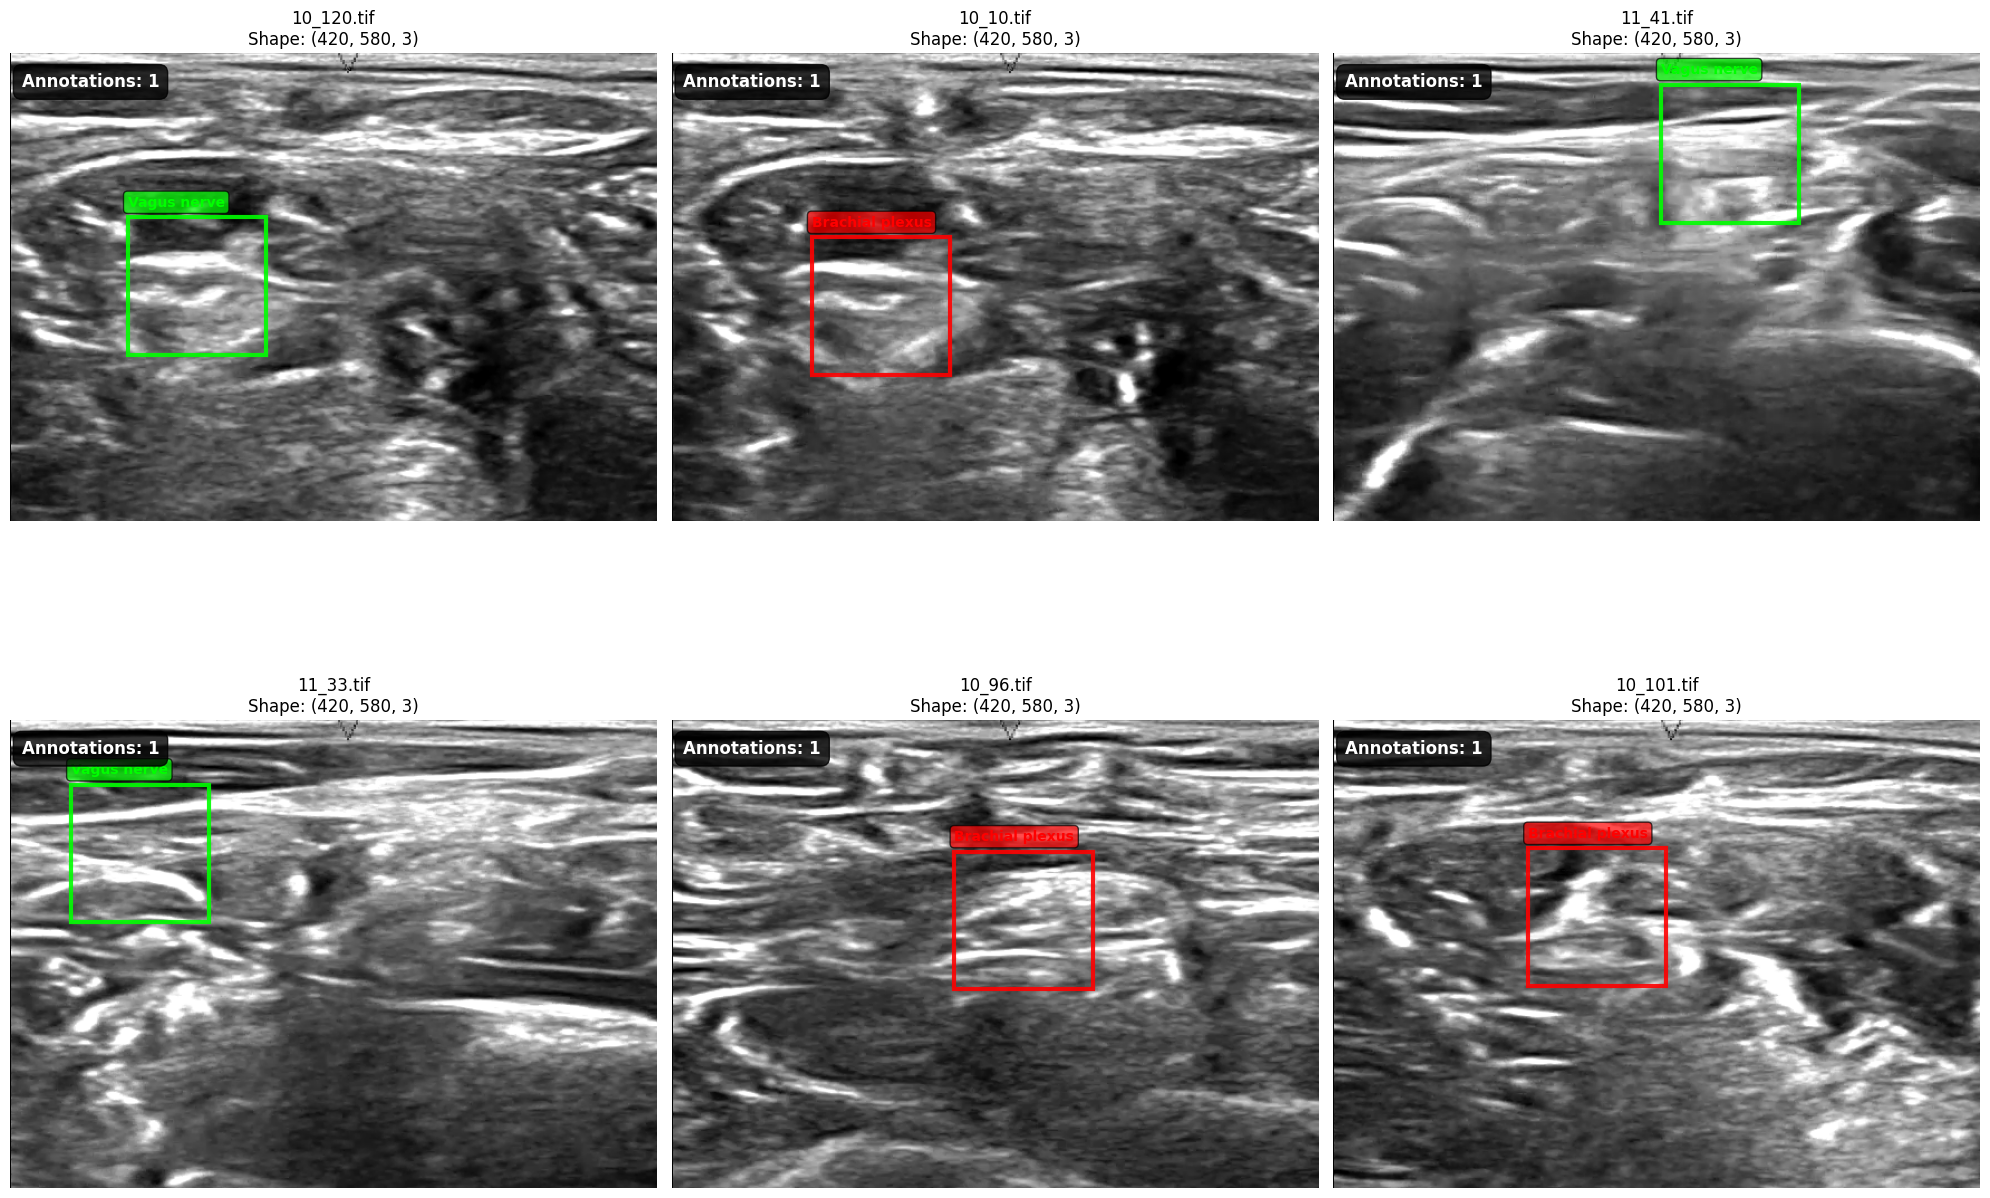

In [8]:
### 7. Visualize annotations ###
def visualize_annotations():
    """Visualize sample images with annotations"""
    
    print(f"\n ANNOTATION VISUALIZATION:")
    
    train_images_path = os.path.join(rgb_dataset_path, 'images', 'train')
    train_labels_path = os.path.join(rgb_dataset_path, 'labels', 'train')
    
    if not os.path.exists(train_images_path):
        print("Train images path not found!")
        return
        
    image_files = [f for f in os.listdir(train_images_path) if f.lower().endswith(('.jpg', '.png', '.jpeg','.tif'))]
    
    if len(image_files) == 0:
        print("No images found!")
        return
    
    plt.figure(figsize=(20, 15))
    
    for i, img_file in enumerate(image_files[:6]):  # Show first 6 images
        if i >= 6:
            break
            
        img_path = os.path.join(train_images_path, img_file)
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(train_labels_path, label_file)
        
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        plt.subplot(2, 3, i+1)
        plt.imshow(img_rgb)
        plt.title(f"{img_file}\nShape: {img_rgb.shape}")
        plt.axis('off')
        
        # Draw annotations if they exist
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            colors = ['red', 'lime']  # Red for class 0, Green for class 1
            class_names = ['Brachial plexus', 'Vagus nerve']
            
            annotation_count = 0
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                
                try:
                    parts = line.split()
                    if len(parts) != 5:
                        continue
                        
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Convert normalized coordinates to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h
                    
                    # Calculate bounding box corners
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)
                    
                    # Draw rectangle
                    import matplotlib.patches as patches
                    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                           linewidth=3, edgecolor=colors[class_id], 
                                           facecolor='none', alpha=0.9)
                    plt.gca().add_patch(rect)
                    
                    # Add class label
                    plt.text(x1, y1-10, f"{class_names[class_id]}", 
                            color=colors[class_id], fontsize=10, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[class_id], alpha=0.7))
                    
                    annotation_count += 1
                    
                except Exception as e:
                    print(f"Error drawing annotation in {img_file}: {e}")
                    
            plt.text(10, 30, f"Annotations: {annotation_count}", 
                    color='white', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='black', alpha=0.8))
        else:
            plt.text(w//2, h//2, "NO LABELS FOUND", 
                    color='red', fontsize=16, fontweight='bold',
                    ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(WORKING_DIR, 'annotation_visualization.png'), dpi=200, bbox_inches='tight')
    plt.show()

# Visualize the annotations
visualize_annotations()

In [9]:
### 8. Training with optimal settings if data is good ###
if analysis_results and analysis_results['train_valid'] > 0:
    
    print(f"\n{'='*60}")
    print(" TRAINING WITH OPTIMIZED SETTINGS")
    print(f"{'='*60}")
    
    print(f"Found {analysis_results['train_valid']} training annotations")
    print(f"Found {analysis_results['val_valid']} validation annotations")
    
    if analysis_results['val_valid'] == 0:
        print("  WARNING: No validation annotations found!")
        print("This will result in 0.0 mAP scores")
    
    # Load model
    model = YOLO("yolov8n.pt")  # Using nano for faster training
    
    # Optimal training configuration for medical detection
    training_config = {
        'data': WORKING_YAML_PATH,
        'epochs': 100,  # More epochs for medical data
        'batch': 16,     # Small batch for stability
        'imgsz': 640,
        'device': device,
        'project': WORKING_DIR,
        'name': 'nerve_detection_optimized',
        'exist_ok': True,
        'pretrained': True,
        'optimizer': 'AdamW',
        'lr0': 0.001,   # Conservative learning rate
        'lrf': 0.0001,
        'momentum': 0.9,
        'weight_decay': 0.05,
        'warmup_epochs': 10,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        
        # Loss weights
        'box': 15.0,    # High emphasis on localization
        'cls': 3.0,     # High emphasis on classification
        'dfl': 1.5,
        
        # Minimal augmentation for medical images
        'hsv_h': 0.002,
        'hsv_s': 0.2,
        'hsv_v': 0.1,
        'degrees': 1.0,
        'translate': 0.01,
        'scale': 0.05,
        'shear': 0.0,
        'perspective': 0.0,
        'flipud': 0.0,
        'fliplr': 0.2,
        'mosaic': 0.3,
        'mixup': 0.0,
        'copy_paste': 0.0,
        
        # Detection settings
        'conf': 0.05,
        'iou': 0.4,
        'max_det': 50,
        'save': True,
        'plots': True,
        'val': True,
        'patience': 50,
        'save_period': 25,
        'cache': False,
        'workers': 4,
        'seed': 42,
        'deterministic': True,
        'verbose': True,
        'amp': True,
        'close_mosaic': 30,
    }
    
    try:
        print("Starting optimized training...")
        results = model.train(**training_config)
        
        print(" Training completed!")
        
        # Validate the model
        best_model_path = os.path.join(WORKING_DIR, 'nerve_detection_optimized', 'weights', 'best.pt')
        
        if os.path.exists(best_model_path):
            print(f"\n VALIDATING OPTIMIZED MODEL:")
            
            best_model = YOLO(best_model_path)
            
            val_results = best_model.val(
                data=WORKING_YAML_PATH,
                imgsz=640,
                batch=4,
                conf=0.001,   # Very low confidence threshold
                iou=0.3,      # Low IoU threshold
                device=device,
                plots=True,
                save_json=True,
                verbose=True
            )
            
            print(f"\n FINAL RESULTS:")
            print(f"  mAP50: {val_results.box.map50:.4f}")
            print(f"  mAP50-95: {val_results.box.map:.4f}")
            print(f"  Precision: {val_results.box.mp:.4f}")
            print(f"  Recall: {val_results.box.mr:.4f}")
            
            if val_results.box.map50 > 0.0:
                print("🎉 SUCCESS: Model is detecting objects!")
                
                # Test on a few images
                val_images_path = os.path.join(rgb_dataset_path, 'images', 'val')
                test_images = [f for f in os.listdir(val_images_path) 
                              if f.lower().endswith(('.jpg', '.png', '.jpeg','.tif'))][:5]
                
                print(f"\n🔍 Testing on sample images:")
                for test_img in test_images:
                    img_path = os.path.join(val_images_path, test_img)
                    results = best_model.predict(
                        source=img_path,
                        conf=0.1,
                        iou=0.3,
                        save=True,
                        project=WORKING_DIR,
                        name='test_predictions'
                    )
                    
                    detections = len(results[0].boxes)
                    print(f"  {test_img}: {detections} detections")
                    
                    if detections > 0:
                        for box in results[0].boxes:
                            conf = box.conf[0].item()
                            cls = int(box.cls[0].item())
                            class_name = working_config['names'][cls]
                            print(f"    - {class_name}: {conf:.3f}")
                
            else:
                print(" Still getting 0.0 mAP - check your annotations manually")
        
    except Exception as e:
        print(f"Training failed: {str(e)}")
        import traceback
        traceback.print_exc()

else:
    print(" Cannot train - no valid annotations found")


 TRAINING WITH OPTIMIZED SETTINGS
Found 34 training annotations
Found 21 validation annotations
Starting optimized training...
Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=15.0, cache=False, cfg=None, classes=None, close_mosaic=30, cls=3.0, conf=0.05, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset_config.yaml, degrees=1.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.2, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.002, hsv_s=0.2, hsv_v=0.1, imgsz=640, int8=False, iou=0.4, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0001, mask_ratio=4, max_det=50, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=0.3, multi_scale=False, name=nerve_detection_opti

train: Scanning /kaggle/working/rgb_dataset/labels/train... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 182.68it/s]

train: New cache created: /kaggle/working/rgb_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 999.3±1093.1 MB/s, size: 229.9 KB)


val: Scanning /kaggle/working/rgb_dataset/labels/val... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<00:00, 1029.76it/s]

val: New cache created: /kaggle/working/rgb_dataset/labels/val.cache


Plotting labels to /kaggle/working/nerve_detection_optimized/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/nerve_detection_optimized
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.09G      7.291      36.29      3.844          2        640: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.1G      6.825      35.96      3.374          3        640: 100%|██████████| 3/3 [00:00<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.11G      6.543      35.16      3.347          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.11G      6.546      36.22      3.239          3        640: 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.27it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.15G      5.779      30.94      2.955          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.17G      3.879      25.27      2.158          3        640: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.19G      3.361      22.54      1.848          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.2G      3.166      21.18      1.744          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.23G      3.026      18.91      1.684          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


                   all         21         21          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.23G      2.817      16.17      1.594          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.26G      2.939      16.28      1.734          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.27G      2.929      15.19      1.674          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.29G      2.502      14.19       1.44          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.3G       2.86      12.81      1.713          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.33G      2.595       11.8      1.613          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.34G      2.641      13.76      1.541          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.36G      2.476      12.75      1.553          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


                   all         21         21          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.38G      2.299      10.79      1.529          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.4G      2.454      10.77       1.52          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.16it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.42G       2.48      11.01      1.514          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.43G      2.355      10.65      1.406          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.45G      2.593      10.08       1.57          3        640: 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.47G      2.551      10.47      1.539          4        640: 100%|██████████| 3/3 [00:00<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.48G      2.631      9.438      1.601          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.70it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.5G      2.371      9.498      1.473          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.63it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.52G      2.262      8.114      1.409          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.54G      2.102      9.449      1.359          1        640: 100%|██████████| 3/3 [00:00<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.55G      1.964      8.098      1.266          4        640: 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.07it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.57G      2.224      8.814      1.371          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.59G      2.113      6.759       1.38          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.59G      2.277      8.755      1.467          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.03it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.62G      2.188      7.646      1.399          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.64G      2.303      7.766       1.45          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.65G      2.462       8.06      1.489          4        640: 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.66G      2.228      6.245      1.403          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.69G      2.435      5.969       1.36          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


                   all         21         21          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.71G      1.723      5.535       1.17          2        640: 100%|██████████| 3/3 [00:00<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.72G      1.639      6.264      1.174          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]

                   all         21         21       0.25     0.0833      0.146     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.73G      1.946       5.95      1.289          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.58it/s]

                   all         21         21       0.25       0.25       0.27      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.76G      1.977      6.685      1.232          3        640: 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]

                   all         21         21      0.208      0.417      0.328      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.77G      1.843      6.885      1.233          2        640: 100%|██████████| 3/3 [00:00<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]

                   all         21         21      0.208      0.417      0.328      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.79G      1.653      5.006      1.149          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]

                   all         21         21      0.154      0.333      0.201      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.8G      1.868      5.701      1.247          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

                   all         21         21      0.167      0.167      0.122     0.0559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.82G      2.115      5.893      1.345          3        640: 100%|██████████| 3/3 [00:00<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]

                   all         21         21      0.332      0.115      0.191      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.84G      1.858        5.2      1.292          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]

                   all         21         21      0.332      0.115      0.191      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.86G      1.737      6.557      1.224          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.72it/s]

                   all         21         21     0.0625     0.0833     0.0365    0.00729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.87G      1.777      5.852      1.256          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.89G      2.032      6.247       1.29          4        640: 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.72it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.91G      1.739      6.262      1.158          2        640: 100%|██████████| 3/3 [00:00<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.93G       1.37      4.291      1.104          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.93G      1.481      4.502       1.16          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.96G      1.786      6.767      1.159          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.98G      1.567      4.103      1.196          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


                   all         21         21          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.99G      1.299      3.513      1.048          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         3G      1.412      3.806       1.07          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.03G      1.862          4      1.224          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.05G      1.834      6.205      1.246          3        640: 100%|██████████| 3/3 [00:00<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.06G      1.646      5.315      1.146          5        640: 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.07G      1.384      4.217      1.059          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       3.1G      1.389      4.014      1.029          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.12G      1.274      3.191      0.999          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.13G      1.265      3.547     0.9601          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.14G      1.688      5.205      1.181          5        640: 100%|██████████| 3/3 [00:00<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.17G      1.478      3.792      1.084          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


                   all         21         21          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.18G      1.415      3.921      1.122          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       3.2G      1.482      3.791       1.08          3        640: 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.21G      1.289      2.955     0.9897          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.23G       1.53      3.475      1.155          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.25G      1.575      3.788        1.1          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


                   all         21         21          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.27G      1.618      5.297      1.227          3        640: 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]

                   all         21         21          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.28G      1.061        2.8     0.9682          2        640: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         21         21     0.0208     0.0833     0.0131    0.00392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       3.3G      1.238      3.222      1.031          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]

                   all         21         21     0.0208     0.0833     0.0125    0.00249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.32G       1.09      2.961     0.9527          2        640: 100%|██████████| 3/3 [00:00<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]

                   all         21         21     0.0208     0.0833     0.0125    0.00249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.34G     0.9388      2.829     0.9601          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.34G      1.098      2.461     0.9838          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]

                   all         21         21          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.37G      1.043      2.511     0.9765          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]

                   all         21         21        0.2     0.0667      0.113     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.39G      1.523      3.082      1.202          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

                   all         21         21        0.2     0.0667      0.113     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       3.4G      1.291      2.727      1.074          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]

                   all         21         21      0.193       0.15       0.11     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.41G     0.8381      2.621     0.9184          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

                   all         21         21      0.125     0.0667     0.0708     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.44G     0.9723      2.497     0.8907          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]

                   all         21         21      0.111     0.0667      0.063     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.46G      1.239      2.616      1.023          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]

                   all         21         21      0.111     0.0667      0.063     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.47G      1.007      2.324     0.9842          2        640: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all         21         21      0.125     0.0667     0.0708     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.48G      1.009      2.896     0.9095          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]

                   all         21         21      0.143     0.0667     0.0842     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.51G      1.198      2.504      0.993          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]

                   all         21         21      0.202      0.183       0.13     0.0381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.52G     0.8865      2.365      0.904          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]

                   all         21         21      0.202      0.183       0.13     0.0381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.54G      1.249      2.787          1          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]

                   all         21         21      0.193      0.267      0.156     0.0613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.55G     0.8198      2.495     0.9311          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]

                   all         21         21      0.261      0.238      0.136     0.0554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.57G      1.021      2.152     0.9734          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         21         21      0.188       0.35      0.144     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.59G     0.8994      2.263     0.9154          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         21         21      0.188       0.35      0.144     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.61G     0.8832      2.327     0.9566          2        640: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]

                   all         21         21       0.19       0.35      0.134     0.0559
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



90 epochs completed in 0.019 hours.
Optimizer stripped from /kaggle/working/nerve_detection_optimized/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/nerve_detection_optimized/weights/best.pt, 6.2MB

Validating /kaggle/working/nerve_detection_optimized/weights/best.pt...
Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         21         21      0.208      0.417      0.328      0.161
 Brachial plexus nerve          6          6      0.417      0.833      0.657      0.321
           Vagus nerve         15         15          0          0          0          0
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /kaggle/working/nerve_detection_optimized
 Training completed!

 VALIDATING OPTIMIZED MODEL:
Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2687.7±1243.5 MB/s, size: 234.9 KB)


val: Scanning /kaggle/working/rgb_dataset/labels/val.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.36it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         21         21       0.78      0.333       0.39      0.176
 Brachial plexus nerve          6          6       0.56      0.667      0.676      0.309
           Vagus nerve         15         15          1          0      0.104     0.0427
Speed: 2.6ms preprocess, 9.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val

 FINAL RESULTS:
  mAP50: 0.3900
  mAP50-95: 0.1758
  Precision: 0.7802
  Recall: 0.3333
🎉 SUCCESS: Model is detecting objects!

🔍 Testing on sample images:

image 1/1 /kaggle/working/rgb_dataset/images/val/11_94.tif: 480x640 (no detections), 35.3ms
Speed: 2.5ms preprocess, 35.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /kaggle/working/test_predictions
  11_94.tif: 0 detections

image 1/1 /kaggle/working/rgb_dataset/images/val/11_81.tif: 480x640 (no detections), 6.1ms
Speed: 2.1ms preprocess, 6.1ms inference, 0.7ms postprocess 

In [10]:
### 9. Final recommendations ###
print(f"\n{'='*60}")
print(" FINAL RECOMMENDATIONS")
print(f"{'='*60}")

if analysis_results:
    if analysis_results['val_valid'] == 0:
        print(" CRITICAL: Add annotations to validation images")
        print(" Validation set must have annotations for mAP calculation")
    
    if analysis_results['train_valid'] < 50:
        print(" Consider getting more training data (current: very few)")
    
    if analysis_results['train_issues'] > 0 or analysis_results['val_issues'] > 0:
        print(" Fix annotation format issues")
    
    print(f"Check the visualization image: annotation_visualization.png")
    print(f" Verify bounding boxes match actual nerve locations")
    print(f" Use very low confidence thresholds for medical detection")

print(f"\n Analysis complete! Check the outputs above for specific issues.")


 FINAL RECOMMENDATIONS
 Consider getting more training data (current: very few)
Check the visualization image: annotation_visualization.png
 Verify bounding boxes match actual nerve locations
 Use very low confidence thresholds for medical detection

 Analysis complete! Check the outputs above for specific issues.
